In [46]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings

warnings.filterwarnings('ignore', message='FigureCanvasAgg is non-interactive')

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 100

In [47]:
# define universe of discourse
rainfall_R = np.linspace(0, 2000, 500)
soil_K = np.linspace(0, 1, 500)
slope_LS = np.linspace(0, 10, 500)
cover_C = np.linspace(0, 1, 500)
support_P = np.linspace(0, 1, 500)
risk_level = np.linspace(0, 1, 500)

# fuzzy variables for the control system
length_slope = ctrl.Antecedent(slope_LS, 'Length-Slope (LS)')
cover = ctrl.Antecedent(cover_C, 'Cover (C)')
rainfall = ctrl.Antecedent(rainfall_R, 'Rainfall (R)')
soil = ctrl.Antecedent(soil_K, 'Soil (K)')
support = ctrl.Antecedent(support_P, 'Support (P)')

risk = ctrl.Consequent(risk_level, 'Risk Level')

# assign membership functions to fuzzy variables
length_slope['Low'] = fuzz.trapmf(slope_LS, [0, 0, 2, 4])
length_slope['Medium'] = fuzz.trimf(slope_LS, [2, 5, 8])
length_slope['High'] = fuzz.trapmf(slope_LS, [4, 8, 10, 10])

cover['Good'] = fuzz.trapmf(cover_C, [0, 0, 0.1, 0.5])
cover['Moderate'] = fuzz.trimf(cover_C, [0.3, 0.6, 0.8])
cover['Poor'] = fuzz.trapmf(cover_C, [0.6, 0.8, 1.0, 1.0])

rainfall['Low'] = fuzz.trapmf(rainfall_R, [0, 0, 400, 800])
rainfall['Medium'] = fuzz.trimf(rainfall_R, [600, 1000, 1400])
rainfall['High'] = fuzz.trapmf(rainfall_R, [1200, 1600, 2000, 2000])

soil['Low'] = fuzz.trapmf(soil_K, [0, 0, 0.2, 0.4])
soil['Medium'] = fuzz.trimf(soil_K, [0.2, 0.4, 0.6])
soil['High'] = fuzz.trapmf(soil_K, [0.4, 0.6, 1.0, 1.0])   

support['Good'] = fuzz.trapmf(support_P, [0, 0, 0.2, 0.4])
support['Moderate'] = fuzz.trimf(support_P, [0.3, 0.5, 0.7])
support['Poor'] = fuzz.trapmf(support_P, [0.6, 0.8, 1.0, 1.0])

risk['Low Risk'] = fuzz.trapmf(risk_level, [0, 0, 0.2, 0.4])
risk['Medium Risk'] = fuzz.trimf(risk_level, [0.3, 0.5, 0.7])
risk['High Risk'] = fuzz.trapmf(risk_level, [0.6, 0.8, 1.0, 1.0])

rules = [
    # slope-cover foundation 
    ctrl.Rule(length_slope['Low'] & cover['Good'], risk['Low Risk']),
    ctrl.Rule(length_slope['Low'] & cover['Moderate'], risk['Low Risk']),
    ctrl.Rule(length_slope['Low'] & cover['Poor'], risk['Medium Risk']),
    ctrl.Rule(length_slope['Medium'] & cover['Good'], risk['Low Risk']),
    ctrl.Rule(length_slope['Medium'] & cover['Moderate'], risk['Medium Risk']),
    ctrl.Rule(length_slope['Medium'] & cover['Poor'], risk['High Risk']),
    ctrl.Rule(length_slope['High'] & cover['Good'], risk['Medium Risk']),
    ctrl.Rule(length_slope['High'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(length_slope['High'] & cover['Poor'], risk['High Risk']),

    # rainfall amplifiers
    ctrl.Rule(rainfall['High'] & length_slope['Medium'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(rainfall['High'] & length_slope['Medium'] & cover['Good'], risk['Medium Risk']),
    ctrl.Rule(rainfall['High'] & length_slope['Low'] & cover['Poor'], risk['Medium Risk']),
    ctrl.Rule(rainfall['Low'] & length_slope['Medium'] & cover['Moderate'], risk['Low Risk']),
    ctrl.Rule(rainfall['Low'] & length_slope['High'] & cover['Good'], risk['Medium Risk']),
    ctrl.Rule(rainfall['High'] & length_slope['High'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(rainfall['High'] & length_slope['High'] & cover['Good'], risk['High Risk']),

    # soil erodibility 
    ctrl.Rule(soil['High'] & length_slope['Medium'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(soil['High'] & length_slope['Low'] & cover['Poor'], risk['Medium Risk']),
    ctrl.Rule(soil['High'] & length_slope['High'] & cover['Good'], risk['High Risk']),
    ctrl.Rule(soil['Low'] & length_slope['Medium'] & cover['Moderate'], risk['Low Risk']),
    ctrl.Rule(soil['Low'] & length_slope['High'] & cover['Good'], risk['Medium Risk']),
    ctrl.Rule(soil['High'] & support['Good'] & cover['Good'], risk['Medium Risk']),

    # support practices 
    ctrl.Rule(support['Good'] & length_slope['High'] & cover['Moderate'], risk['Medium Risk']),
    ctrl.Rule(support['Good'] & length_slope['Medium'] & cover['Moderate'], risk['Medium Risk']),
    ctrl.Rule(support['Good'] & cover['Good'], risk['Low Risk']),
    ctrl.Rule(support['Poor'] & length_slope['High'], risk['High Risk']),
    ctrl.Rule(support['Poor'] & length_slope['Medium'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(support['Good'] & soil['High'] & cover['Moderate'], risk['Medium Risk']),

    # complex interactions
    ctrl.Rule(rainfall['Medium'] & soil['Medium'] & length_slope['Medium'] & cover['Moderate'], risk['Medium Risk']),
    ctrl.Rule(rainfall['Medium'] & soil['Low'] & length_slope['Low'], risk['Low Risk']),
    ctrl.Rule(rainfall['High'] & soil['Medium'] & length_slope['High'] & cover['Moderate'], risk['High Risk']),
    ctrl.Rule(rainfall['Low'] & soil['High'] & support['Poor'], risk['Medium Risk']),
    ctrl.Rule(rainfall['High'] & soil['High'] & length_slope['High'], risk['High Risk']),
    ctrl.Rule(support['Good'] & rainfall['High'] & cover['Good'], risk['Medium Risk']),
    ctrl.Rule(support['Poor'] & rainfall['High'] & soil['High'], risk['High Risk'])
]

erosion_risk_ctrl = ctrl.ControlSystem(rules)
erosion_risk = ctrl.ControlSystemSimulation(erosion_risk_ctrl)

# print("Fuzzy control system successfully created with the following rules:")
# for i, rule in enumerate(rules, 1):
#     print(f"Rule {i}: IF '{rule.antecedent}' THEN '{rule.consequent}'") 

In [48]:
def risk_output(sim, inputs):
    risk_val = sim.output['Risk Level']
    
    # calculate membership in each risk category
    memberships = {
        'Low': fuzz.interp_membership(risk_level, risk['Low Risk'].mf, risk_val),
        'Medium': fuzz.interp_membership(risk_level, risk['Medium Risk'].mf, risk_val),
        'High': fuzz.interp_membership(risk_level, risk['High Risk'].mf, risk_val)
    }
    
    primary_class = max(memberships, key=memberships.get)
    confidence = memberships[primary_class]

    # identify primary drivers based on threshold values
    R, K, LS, C, P = inputs
    drivers = []
    if LS > 7: drivers.append("Steep slope")
    if C > 0.7: drivers.append("Poor cover")
    if R > 1400: drivers.append("High rainfall")
    if K > 0.6: drivers.append("Erodible soil")
    if P > 0.7: drivers.append("Weak support practices")
    
    return risk_val, primary_class, confidence


______________________________________________________________________
Scenario A
Erosion Risk Assessment:
 Risk Level: 0.156 (Low Risk)
 Confidence: 100.0%
 Membership Degrees - Low: 1.00, Medium: 0.00, High: 0.00
______________________________________________________________________


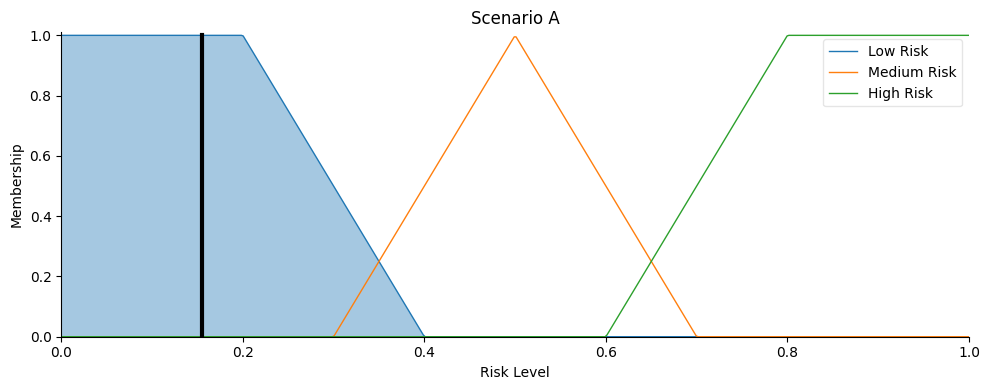

______________________________________________________________________
Scenario B
Erosion Risk Assessment:
 Risk Level: 0.176 (Low Risk)
 Confidence: 100.0%
 Membership Degrees - Low: 1.00, Medium: 0.00, High: 0.00
______________________________________________________________________


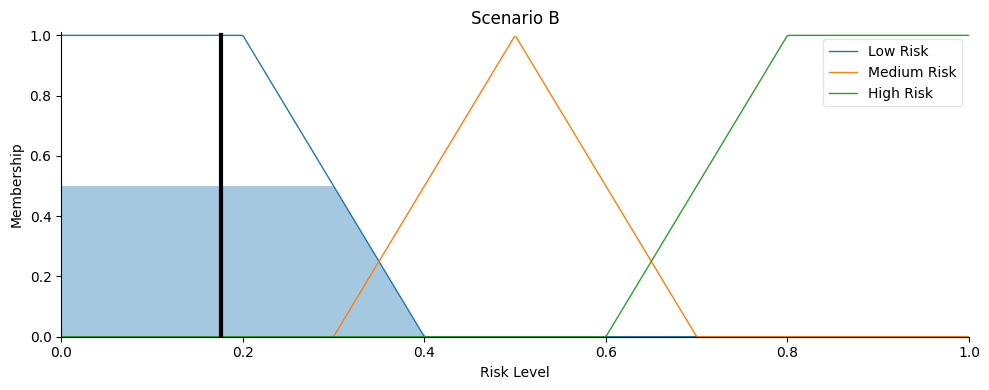

______________________________________________________________________
Scenario C
Erosion Risk Assessment:
 Risk Level: 0.604 (Medium Risk)
 Confidence: 47.8%
 Membership Degrees - Low: 0.00, Medium: 0.48, High: 0.02
______________________________________________________________________


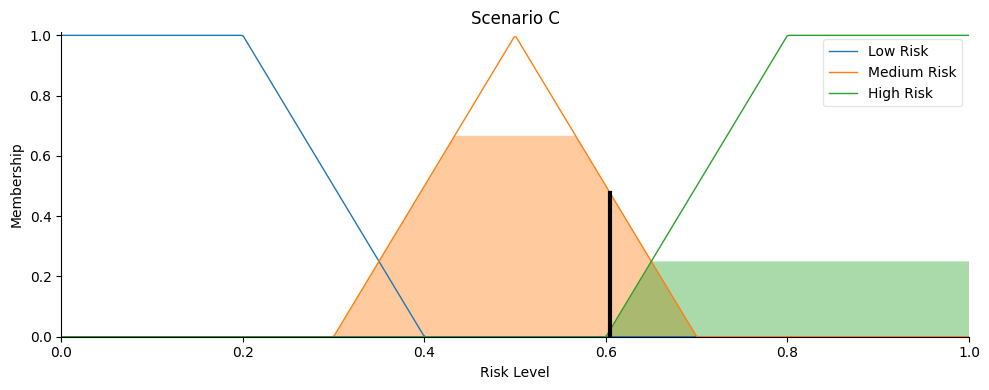

______________________________________________________________________
Scenario D
Erosion Risk Assessment:
 Risk Level: 0.297 (Low Risk)
 Confidence: 51.5%
 Membership Degrees - Low: 0.51, Medium: 0.00, High: 0.00
______________________________________________________________________
______________________________________________________________________
Scenario E
Erosion Risk Assessment:
 Risk Level: 0.843 (High Risk)
 Confidence: 100.0%
 Membership Degrees - Low: 0.00, Medium: 0.00, High: 1.00
______________________________________________________________________
______________________________________________________________________
Scenario F
Erosion Risk Assessment:
 Risk Level: 0.844 (High Risk)
 Confidence: 100.0%
 Membership Degrees - Low: 0.00, Medium: 0.00, High: 1.00
______________________________________________________________________
______________________________________________________________________
Scenario G
Erosion Risk Assessment:
 Risk Level: 0.292 (Low Risk)
 Con

In [ ]:
def simulate_erosion_risk(rainfall_val, soil_val, slope_val, cover_val, support_val, show_plot=True): 
    
    risk_simulator = ctrl.ControlSystemSimulation(erosion_risk_ctrl)

    risk_simulator.input['Rainfall (R)'] = rainfall_val
    risk_simulator.input['Soil (K)'] = soil_val
    risk_simulator.input['Length-Slope (LS)'] = slope_val
    risk_simulator.input['Cover (C)'] = cover_val
    risk_simulator.input['Support (P)'] = support_val
    
    risk_simulator.compute()
    inputs = (rainfall_val, soil_val, slope_val, cover_val, support_val)
    risk_val, risk_class, confidence = risk_output(risk_simulator, inputs)

    print('_'*70)
    print(f"{scenario_name}")
    print(f"Erosion Risk Assessment:")
    print(f" Risk Level: {risk_val:.3f} ({risk_class} Risk)")
    print(f" Confidence: {confidence:.1%}")
    print(f" Membership Degrees - Low: {fuzz.interp_membership(risk_level, risk['Low Risk'].mf, risk_val):.2f}, Medium: {fuzz.interp_membership(risk_level, risk['Medium Risk'].mf, risk_val):.2f}, High: {fuzz.interp_membership(risk_level, risk['High Risk'].mf, risk_val):.2f}")
    print('_'*70)
    
    if show_plot:
        risk.view(sim=risk_simulator)
        plt.title(scenario_name)
        plt.tight_layout()
        plt.show()
    
    return risk_val, risk_class

# input test input here
test_scenarios = {
    "Scenario A": {
        "inputs": (200, 0.1, 1, 0.05, 0.1),
        "description": "Minimal rainfall intensity, gentle terrain, dense vegetation"
    },
    "Scenario B": {
        "inputs": (500, 0.3, 3, 0.2, 0.3),
        "description": "Moderate rainfall, low-medium slope, good vegetation cover"
    },
    "Scenario C": {
        "inputs": (1000, 0.4, 5, 0.5, 0.5),
        "description": "Medium rainfall and soil erodibility, moderate slope and cover"
    },
    "Scenario D": {
        "inputs": (800, 0.3, 7, 0.15, 0.2),
        "description": "Steep terrain with excellent vegetation and conservation practices"
    },
    "Scenario E": {
        "inputs": (800, 0.5, 9, 0.9, 0.8),
        "description": "Very steep slope, minimal vegetation, limited conservation"
    },
    "Scenario F": {
        "inputs": (1800, 0.9, 10, 1.0, 1.0),
        "description": "Intense rainfall, highly erodible soil, maximum slope steepness"
    },
    "Scenario G": {
        "inputs": (1800, 0.2, 2, 0.1, 0.1),
        "description": "Very high rainfall with low soil erodibility and excellent protection"
    },
}

for scenario_name, scenario_data in test_scenarios.items():
    inputs = scenario_data["inputs"]
    description = scenario_data["description"]
    
    # only display first 3 plots to avoid clutter
    show_plot = list(test_scenarios.keys()).index(scenario_name) < 3
    simulate_erosion_risk(*inputs, show_plot=show_plot)

## Summary Table of Results

In [50]:
summary_data = []

for scenario_name, scenario_data in test_scenarios.items():
    inputs = scenario_data["inputs"]
    R, K, LS, C, P = inputs
    
    # run simulation without plot
    risk_simulator = ctrl.ControlSystemSimulation(erosion_risk_ctrl)
    risk_simulator.input['Rainfall (R)'] = R
    risk_simulator.input['Soil (K)'] = K
    risk_simulator.input['Length-Slope (LS)'] = LS
    risk_simulator.input['Cover (C)'] = C
    risk_simulator.input['Support (P)'] = P
    risk_simulator.compute()
    
    risk_val = risk_simulator.output['Risk Level']
    
    A = R * K * LS * C * P
    
    if risk_val <= 0.4:
        fuzzy_class = "Low"
    elif risk_val <= 0.7:
        fuzzy_class = "Medium"
    else:
        fuzzy_class = "High"
    
    if A < 5:
        rusle_class = "Low"
    elif A < 15:
        rusle_class = "Moderate"
    else:
        rusle_class = "High"
    
    summary_data.append({
        'Scenario': scenario_name.split(' ')[1],
        'R': R,
        'K': K,
        'LS': LS,
        'C': C,
        'P': P,
        'Fuzzy Risk': f"{risk_val:.3f}",
        'Fuzzy Class': fuzzy_class,
        'RUSLE A': f"{A:.2f}",
        'RUSLE Class': rusle_class
    })

df_summary = pd.DataFrame(summary_data)
df_summary.to_string(index=False)
df_summary

,Scenario,R,K,LS,C,P,Fuzzy Risk,Fuzzy Class,RUSLE A,RUSLE Class
0,A,200,0.1,1,0.05,0.1,0.156,Low,0.10,Low
1,B,500,0.3,3,0.20,0.3,0.176,Low,27.00,High
2,C,1000,0.4,5,0.50,0.5,0.604,Medium,500.00,High
3,D,800,0.3,7,0.15,0.2,0.297,Low,50.40,High
4,E,800,0.5,9,0.90,0.8,0.843,High,2592.00,High
5,F,1800,0.9,10,1.00,1.0,0.844,High,16200.00,High
6,G,1800,0.2,2,0.10,0.1,0.292,Low,7.20,Moderate
